In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from pandas import DataFrame
# 设定随机数种子
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
import os
os.environ['PYTHONHASHSEED'] = '0'
import random as rn
rn.seed(42)

In [2]:
# 设定输出图片的大小和图片中的字体大小
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [3]:
# 不显示warning
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 读取数据的同时把data转换为datetime格式并设为Index
df = pd.read_csv('food.csv',parse_dates = True, index_col=0)
df.head()

,seed_area,irri_area,mach_power,fert_amount,food_output
year,,,,,
1978-01-01,150104.0,44965.3,11749.9,884.0,30476.5
1980-01-01,146379.0,44888.1,14745.7,1269.4,32055.5
1985-01-01,143626.0,44035.9,20912.5,1775.8,37910.8
1986-01-01,144204.0,NaN,22950.0,NaN,NaN
1987-01-01,144957.0,NaN,24836.0,NaN,NaN


In [5]:
# 索引保留年份
df.index = df.index.year
# 因为前部分数据存在空值，删除，使用的数据从1990年开始
df = df[7:]
df.head()

,seed_area,irri_area,mach_power,fert_amount,food_output
year,,,,,
1990,148362.0,47403.1,28707.7,2590.3,44624.3
1991,149586.0,47822.1,29388.6,2805.1,43529.3
1992,149007.0,48590.1,30308.4,2930.2,44265.8
1993,147741.0,48727.9,31816.6,3151.9,45648.8
1994,148241.0,48759.1,33802.5,3317.9,44510.1


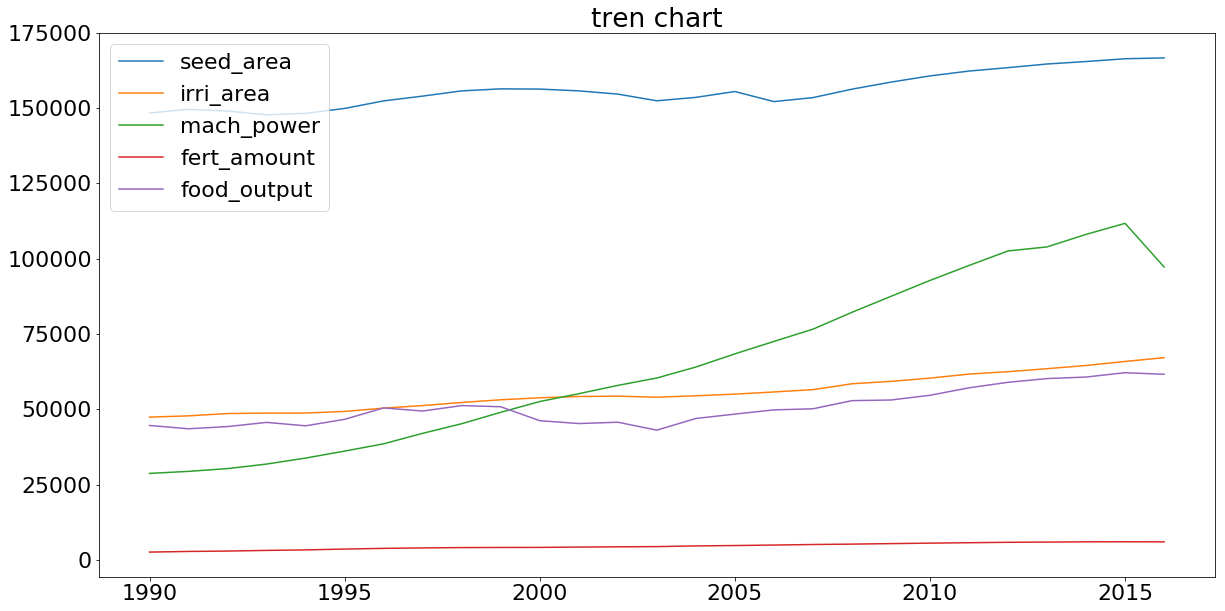

In [6]:
# 画图各个特征的走势图，观察趋势以及判断有无异常值
plt.plot(df.index, df.seed_area,label='seed_area')
plt.plot(df.index, df.irri_area,label='irri_area')
plt.plot(df.index, df.mach_power,label='mach_power')
plt.plot(df.index, df.fert_amount,label='fert_amount')
plt.plot(df.index, df.food_output,label='food_output')
plt.legend(loc='upper left')
plt.title("tren chart")
plt.show()

### 模型1：对未归一化的数据使用SVR模型

In [7]:
# 把数据集划分成训练集和测试集
data = df.values
X = data[:,:-1]
y = data[:,-1]
train_X = X[:20]
test_X = X[20:]
train_y = y[:20]
test_y = y[20:]

In [8]:
from sklearn.svm import SVR
# 使用SVR训练模型并预测
clf_svr = SVR(kernel='linear',C = 0.8)
clf_svr.fit(train_X, train_y.ravel())

pre = clf_svr.predict(test_X)
pre_list = pre.tolist()
true_list = test_y.tolist()

# 误差定义
error = sum(list(map(lambda x:abs(abs(x[0] - x[1])/(x[1])), zip(pre_list,true_list))))
print('error',float((error/7)*100),'%')

# 保存预测值，用于最后的画图
svr_pre = pre_list

('error', 2.5850824757965096, '%')


- 误差为2.58%

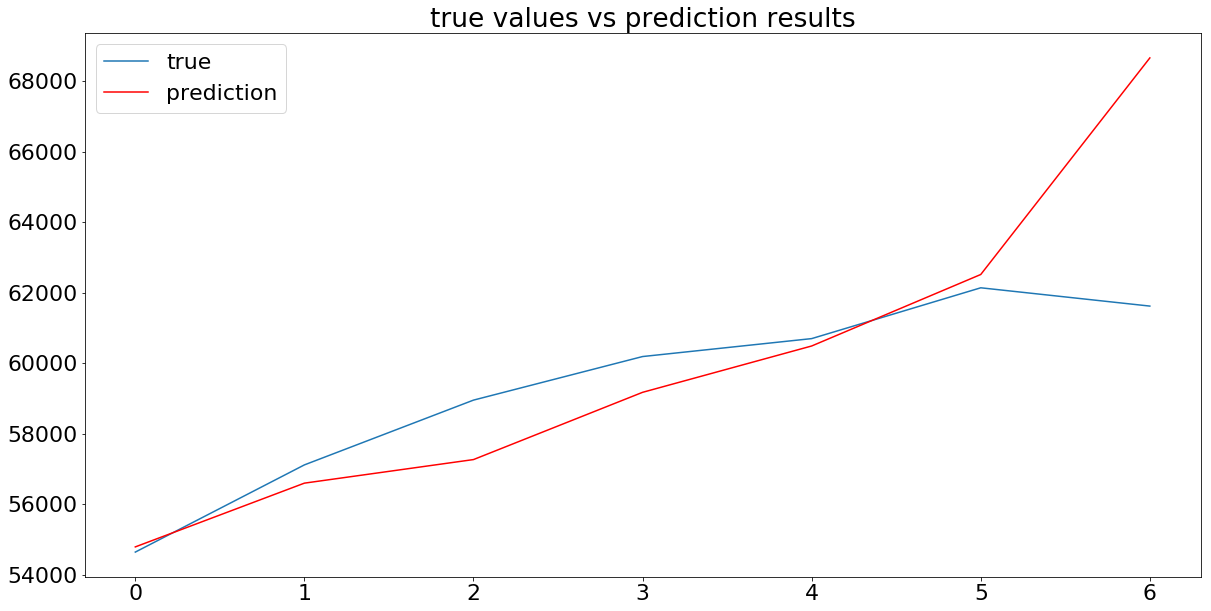

In [9]:
# 画图比较预测值和真实值
plt.plot(true_list,label='true')
plt.plot(pre_list, color='red',label='prediction')
plt.legend(loc='upper left')
plt.title('true values vs prediction results')
plt.show()

### 模型2：滚动预测，还是使用SVR模型

In [10]:
# 分割数据集，splitline为分割索引
def split_dataset(X,y,splitline):
    train_y = y[0:splitline]
    train_X = X[0:splitline,:]
    
    test_y = y[splitline:]
    test_X = X[splitline:,:]
    return train_X,train_y,test_X,test_y

In [11]:
# 用之前的年份的所有数据预测当前年份
data = df.values
X = data[:,:-1]
y = data[:,-1]
y_pre = []
for i in xrange(7):
    splitline = 20+i
    train_X,train_y,test_X,test_y=split_dataset(X,y,splitline)
    model = SVR(kernel='linear',C = 0.8)
    model.fit(train_X, train_y) 
    pre = model.predict(test_X)   
    y_pre.append(pre[0]) 

In [12]:
# 获得真实值
data = df.values
y = data[:,-1]
test_y = y[20:]
true_list = test_y.tolist()

In [13]:
# 误差定义
error = sum(list(map(lambda x:abs(abs(x[0] - x[1])/(x[1])), zip(y_pre,true_list))))
print('error:',float((error/7)*100),'%')
svr_mov_pre = pre_list

('error:', 2.324925596377898, '%')


- 误差为2.32%，相比于直接使用SVR略微减低了一些

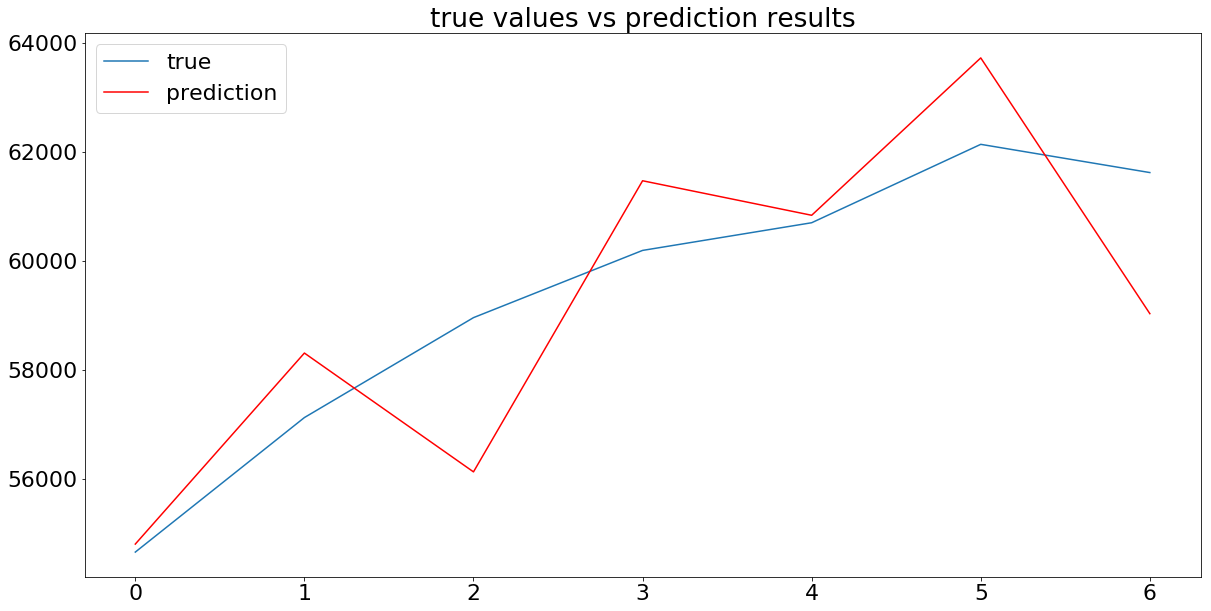

In [14]:
plt.plot(true_list,label='true')
plt.plot(y_pre, color='red',label='prediction')
plt.legend(loc='upper left')
plt.title('true values vs prediction results')
plt.show()

In [15]:
# # 调参
# E = [0.01,0.1,1]
# for e in E:
#     clf_svr = SVR(kernel='linear',epsilon=e,C=0.8)
#     clf_svr.fit(train_X, train_y.ravel())

#     pre = clf_svr.predict(test_X)
#     pre_list = pre.tolist()
#     true_list = test_y.tolist()
#     # 误差定义
#     error = sum(list(map(lambda x:abs(abs(x[0] - x[1])/(x[1])), zip(pre_list,true_list))))
#     print('E:',e,'error',float((error/7)*100),'%')

### 模型3：对数据进行归一化后使用SVR模型

In [16]:
# 获取food_output范围，用于之后还原归一化值
output_range = max(df['food_output']) - min(df['food_output'])
output_min = min(df['food_output'])

In [17]:
output_range, output_min

(19074.37384, 43069.52616)

In [18]:
# 对每一个特征进行极大极小值归一化
for column in df.columns.values:
    min_max_list = []
    min_x = min(df[column])
    max_x = max(df[column])
    range_x = max_x - min_x
    range_norm = 1
    df[column] = df[column].map(lambda x: (x-min_x)/range_x * range_norm)
df.head()

,seed_area,irri_area,mach_power,fert_amount,food_output
year,,,,,
1990,0.032842,0.000000,0.000000,0.000000,0.081511
1991,0.097573,0.021229,0.008202,0.062582,0.024104
1992,0.066952,0.060139,0.019281,0.099030,0.062716
1993,0.000000,0.067121,0.037447,0.163622,0.135222
1994,0.026442,0.068702,0.061368,0.211986,0.075524


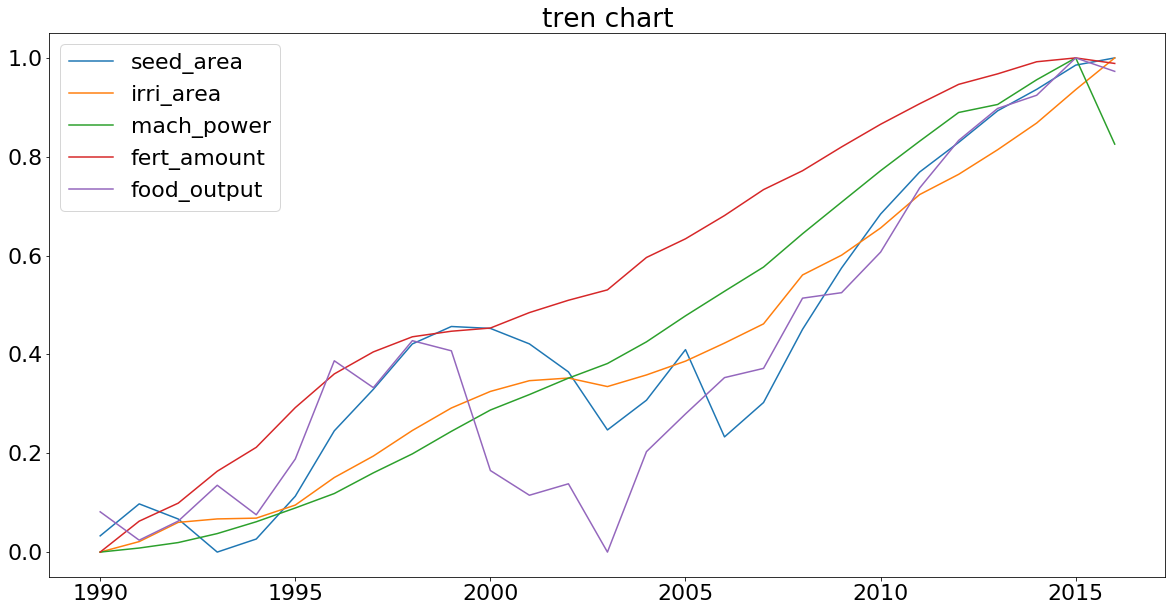

In [19]:
# 画图 各个归一化后特征的走势图，观察趋势以及判断有无异常值
plt.plot(df.index, df.seed_area,label='seed_area')
plt.plot(df.index, df.irri_area,label='irri_area')
plt.plot(df.index, df.mach_power,label='mach_power')
plt.plot(df.index, df.fert_amount,label='fert_amount')
plt.plot(df.index, df.food_output,label='food_output')
plt.title("tren chart")
plt.legend(loc='upper left')
plt.show()

In [20]:
# 把数据集划分成训练集和测试集
data = df.values
X = data[:,:-1]
y = data[:,-1]
train_X = X[:20]
test_X = X[20:]
train_y = y[:20]
test_y = y[20:]

In [21]:
clf_svr = SVR(kernel='linear')
clf_svr.fit(train_X, train_y.ravel())
pre = clf_svr.predict(test_X)
pre_list = pre.tolist()

还原数据

In [22]:
def restore_pre(pre_list, output_range,output_min):
    pre_restore = []
    for i in pre_list:
        true = i * output_range + output_min
        pre_restore.append(true)
    return pre_restore
pre_restore = restore_pre(pre_list,output_range, output_min)
print(pre_restore)

[51901.12036569073, 52507.2706157473, 52978.16118359647, 53376.905497167434, 53723.89536013096, 54037.96872390267, 53980.431035290756]


In [23]:
def restore_true(pre_list, output_range, output_min):
    true_restore = []
    for i in true_list:
        true = i * output_range + output_min
        true_restore.append(true)
    return true_restore

true_list = test_y.tolist()
true_restore = restore_true(pre_list, output_range, output_min)
print(true_restore)

[54647.712, 57120.84906, 58957.96606, 60193.84002999999, 60702.6, 62143.9, 61625.0]


In [24]:
# 误差定义
error = sum(list(map(lambda x:abs(abs(x[0] - x[1])/(x[1])), zip(pre_restore,true_restore))))
print('error',float((error/7)*100),'%')
svr_norm_pre = pre_restore

('error', 10.216523678102371, '%')


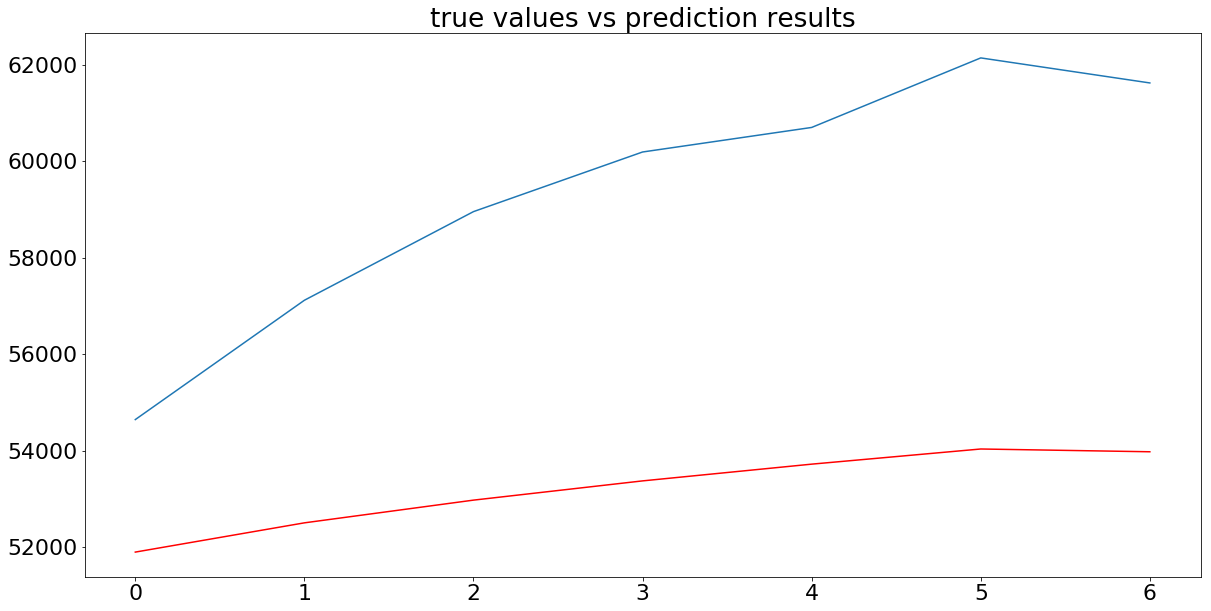

In [25]:
import matplotlib.pyplot as plt
plt.plot(true_restore)
plt.plot(pre_restore, color='red')
plt.title('true values vs prediction results')
plt.show()

- 可见归一化后误差反而增大

### 模型4：对数据进行归一化使用SVR模型滚动预测

In [26]:
# 用之前的年份的所有数据预测当前年份
data = df.values
X = data[:,:-1]
y = data[:,-1]
y_pre = []
for i in xrange(7):
    splitline = 20+i
    train_X,train_y,test_X,test_y=split_dataset(X,y,splitline)
    model = SVR(kernel='linear',C = 0.8)
    model.fit(train_X, train_y) 
    pre = model.predict(test_X)   
    y_pre.append(pre[0])

In [27]:
data = df.values
y = data[:,-1]
test_y = y[20:]
true_list = test_y.tolist()

In [28]:
pre_restore = restore_pre(y_pre,output_range, output_min)
true_restore = restore_true(true_list, output_range, output_min)

In [29]:
# 误差定义
error = sum(list(map(lambda x:abs(abs(x[0] - x[1])/(x[1])), zip(pre_restore,true_restore))))
print('error',float((error/7)*100),'%')
svr_norm_mov = pre_restore

('error', 5.001825962419145, '%')


误差为5%，虽然误差降低，但是不如归一化之前的准确率高

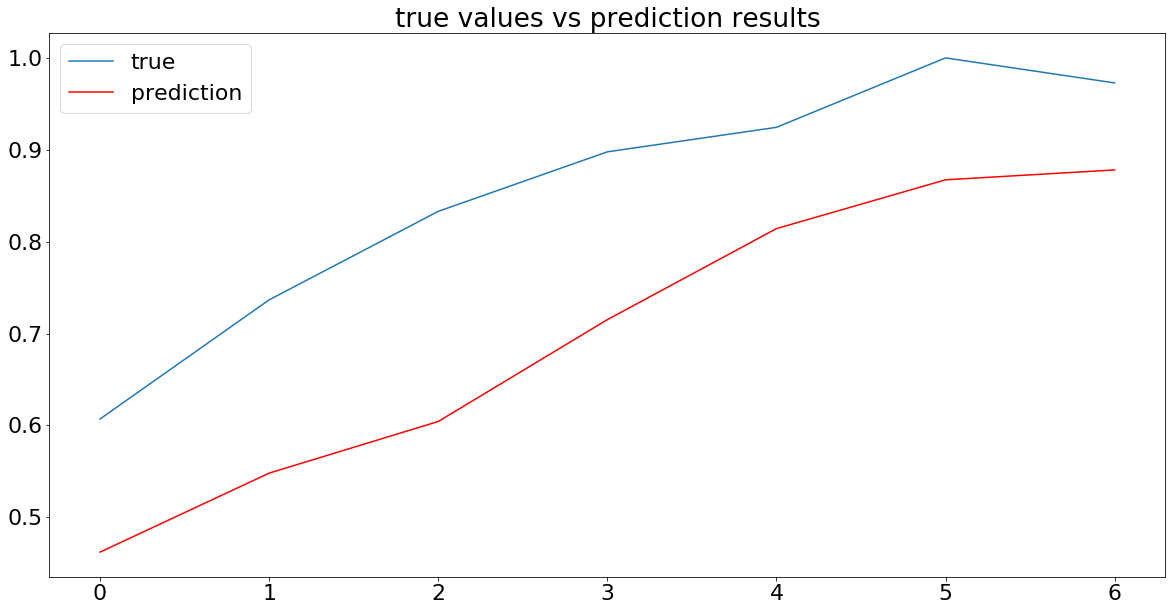

In [30]:
plt.plot(true_list,label='true')
plt.plot(y_pre, color='red',label='prediction')
plt.legend(loc='upper left')
plt.title('true values vs prediction results')
plt.show()

### 模型5：使用神经网络预测

In [31]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adagrad
import numpy as np

Using TensorFlow backend.


In [32]:
model = Sequential()
model.add(Dense(20, activation='relu', input_dim=4))
model.add(Dense(1, activation='linear'))

# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adagrad(lr=0.01, epsilon=1e-06)
model.compile(loss='mse', optimizer='adam')

In [33]:
X = data[:,:-1]
y = data[:,-1]
train_X = X[:20]
test_X = X[20:]
train_y = y[:20]
test_y = y[20:]

In [34]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((20, 4), (7, 4), (20,), (7,))

In [35]:
history = model.fit(train_X, train_y, epochs = 500, batch_size=20, 
    validation_data=(test_X, test_y),verbose=0,shuffle=False)

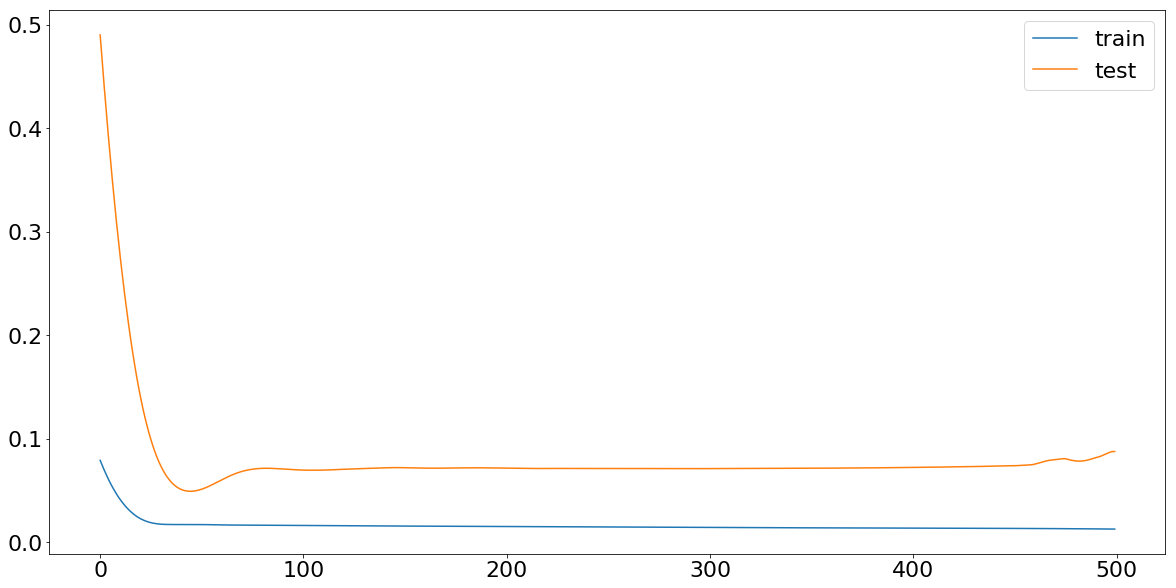

In [36]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [37]:
pre = model.predict(test_X).flatten()
pre_list = pre.tolist()
true_list = test_y.tolist()
pre_restore = restore_pre(pre_list,output_range, output_min)
# print(pre_restore)
true_restore = restore_true(true_list, output_range, output_min)
# print(true_restore)
# 误差定义
error = sum(list(map(lambda x:abs(abs(x[0] - x[1])/(x[1])), zip(pre_restore,true_restore))))
print('error',float((error/7)*100),'%')
nn_norm = pre_restore

('error', 9.130170551183276, '%')


- 误差为：9.14% 神经网络预测效果较差

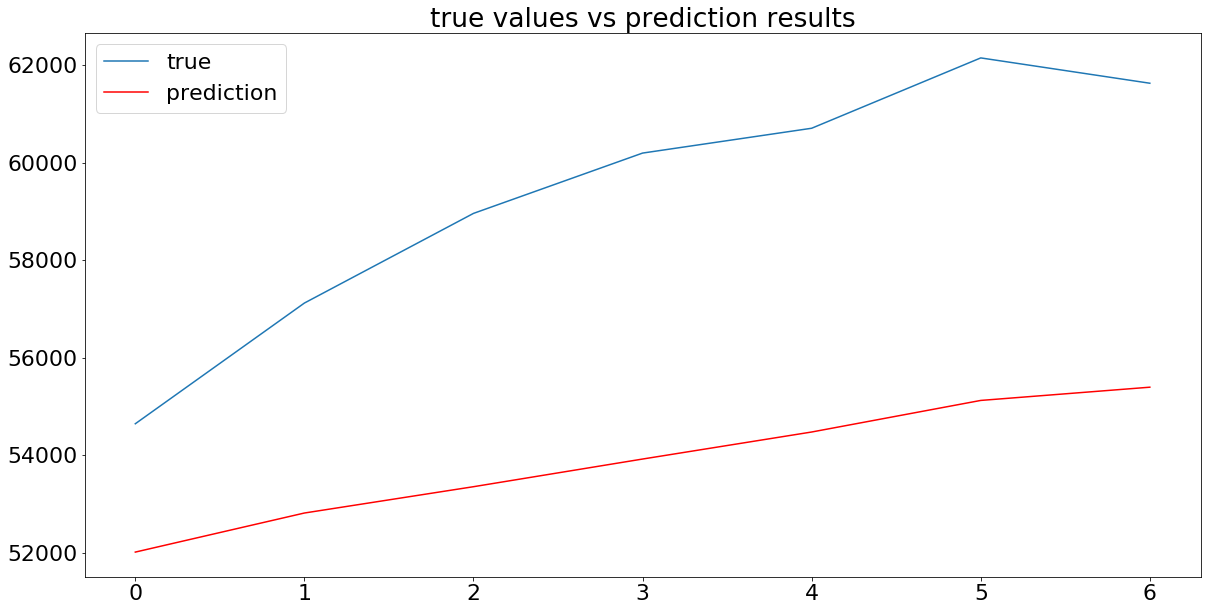

In [38]:
plt.plot(true_restore,label='true')
plt.plot(pre_restore, color='red',label='prediction')
plt.legend(loc='upper left')
plt.title('true values vs prediction results')
plt.show()

### 模型6：使用时间序列模型ARIMA模型预测

In [55]:
# 读取数据的同时把data转换为datetime格式并设为Index
df = pd.read_csv('data/food1.csv',
                parse_dates = True, 
                 index_col=0)

df.index = df.index.year

df = df[7:]

df.tail()

,seed_area,irri_area,mach_power,fert_amount,food_output
year,,,,,
2012,163415.6704,62490.52401,102558.9600,5838.848980,58957.96606
2013,164626.9293,63473.30374,103906.7505,5911.863706,60193.84003
2014,165446.0000,64539.50000,108056.6000,5995.900000,60702.60000
2015,166374.0000,65872.60000,111728.1000,6022.600000,62143.90000
2016,166650.0000,67140.60000,97245.6000,5984.100000,61625.00000


In [56]:
before_diff = df.food_output[19:]

In [57]:
before_diff

year
2009    53082.07765
2010    54647.71200
2011    57120.84906
2012    58957.96606
2013    60193.84003
2014    60702.60000
2015    62143.90000
2016    61625.00000
Name: food_output, dtype: float64

平稳性检验

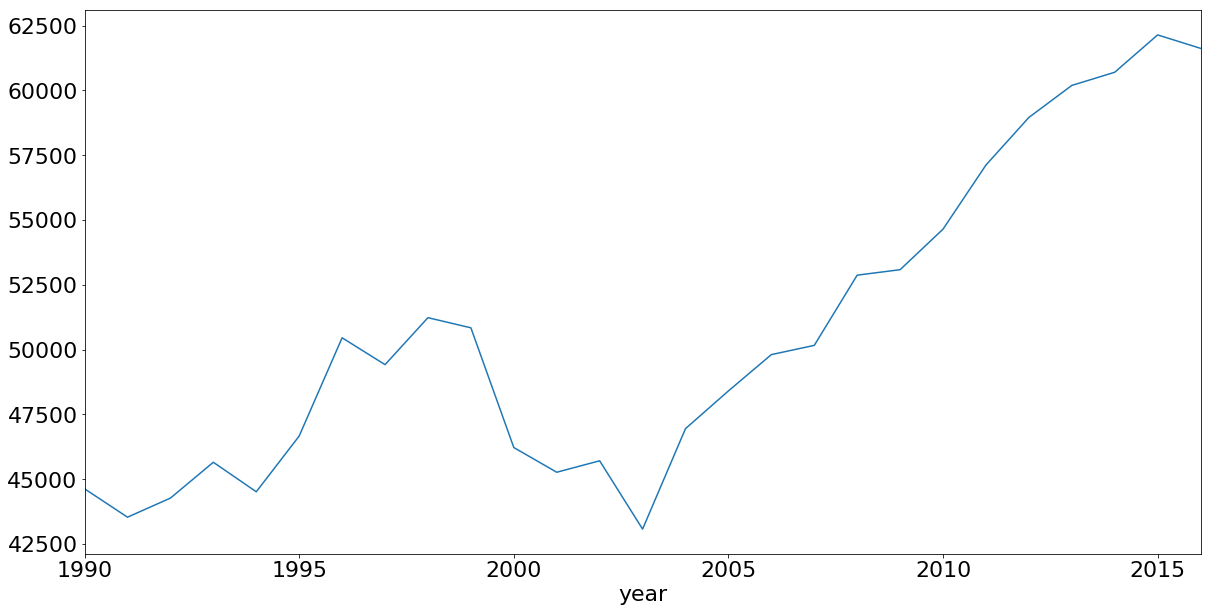

In [25]:
df['food_output'].plot()
plt.show()

In [26]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    return dftest
    #此函数返回的是p值
res = test_stationarity(df.food_output)
res

(0.9028385236820634,
 0.9931272582423158,
 9,
 17,
 {'1%': -3.889265672705068,
  '10%': -2.66698384083045,
  '5%': -3.0543579727254224},
 307.7988822477983)

- 由图像和p-value值可知，该时间序列为非平稳时间序列

对时间序列取一阶差分

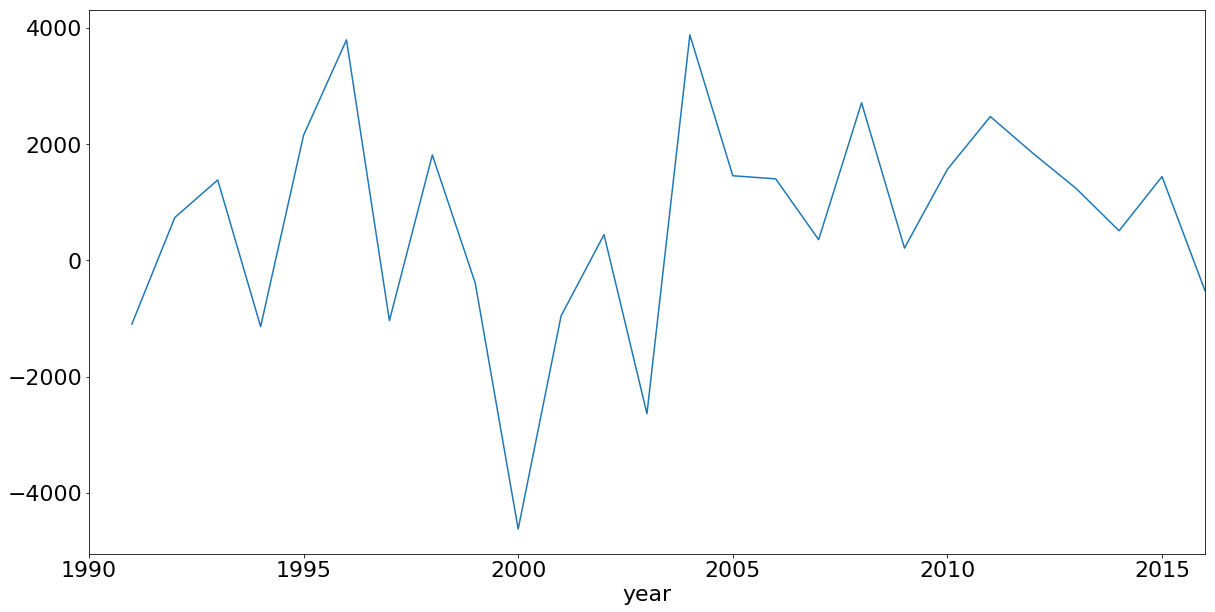

In [27]:
diff1 = df.food_output.diff(1)
diff1.plot()
plt.show()

In [28]:
diff1 = np.asarray(diff1)
df['difference'] = diff1
df = df[1:]
res2 = test_stationarity(df.difference)
res2

(-2.8483345322911013,
 0.05169431179480675,
 9,
 16,
 {'1%': -3.9240193847656246, '10%': -2.67389265625, '5%': -3.0684982031250003},
 275.48287360137294)

- 取一阶差分后时间序列可以看做是平稳时间序列

找到合适的 p q值

In [45]:
import statsmodels.tsa.stattools as st
order = st.arma_order_select_ic(df.difference,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])
order.bic_min_order

/opt/anaconda3/envs/python2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/python2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/python2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/python2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/python2/lib/python2.7/site-packa

/opt/anaconda3/envs/python2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/python2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/python2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/python2/lib/python2.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/envs/python2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa

(0, 2)

In [33]:
# 划分测试集和训练集
true = df.food_output[19:] # 测试集

In [44]:
true

year
2010    54647.71200
2011    57120.84906
2012    58957.96606
2013    60193.84003
2014    60702.60000
2015    62143.90000
2016    61625.00000
Name: food_output, dtype: float64

In [45]:
train = df.difference[:19]
test = df.difference[19:]

In [46]:
test

year
2010    1565.63435
2011    2473.13706
2012    1837.11700
2013    1235.87397
2014     508.75997
2015    1441.30000
2016    -518.90000
Name: difference, dtype: float64

拟合ARMA模型

In [48]:
# 每次预测一天，再把预测好的记录加入训练集
from statsmodels.tsa.arima_model import ARIMA

def compare_ARIMA_modes(order):
    history_f = [x for x in train]
    predictions_f = list()
    for t in range(len(test)):
        model_f = ARIMA(history_f, order=(0,0,2))
        model_fit_f = model_f.fit(disp=-1)
        yhat_f = model_fit_f.forecast()[0][0]
        predictions_f.append(yhat_f)
        history_f.append(yhat_f)
    return {'Predictions forecast': predictions_f}
arima = compare_ARIMA_modes((0, 0, 2))

In [49]:
# 包含predict 和 forecast的预测值
arima

{'Predictions forecast': [289.45473440165983,
  458.479304744712,
  442.1296093669405,
  442.88582115401846,
  442.57229893218204,
  442.6792088709347,
  442.6525504112266]}

In [41]:
test = test.tolist()

In [42]:
test

[1565.6343500000003,
 2473.137060000001,
 1837.1169999999984,
 1235.8739699999933,
 508.75997000000643,
 1441.300000000003,
 -518.9000000000015]

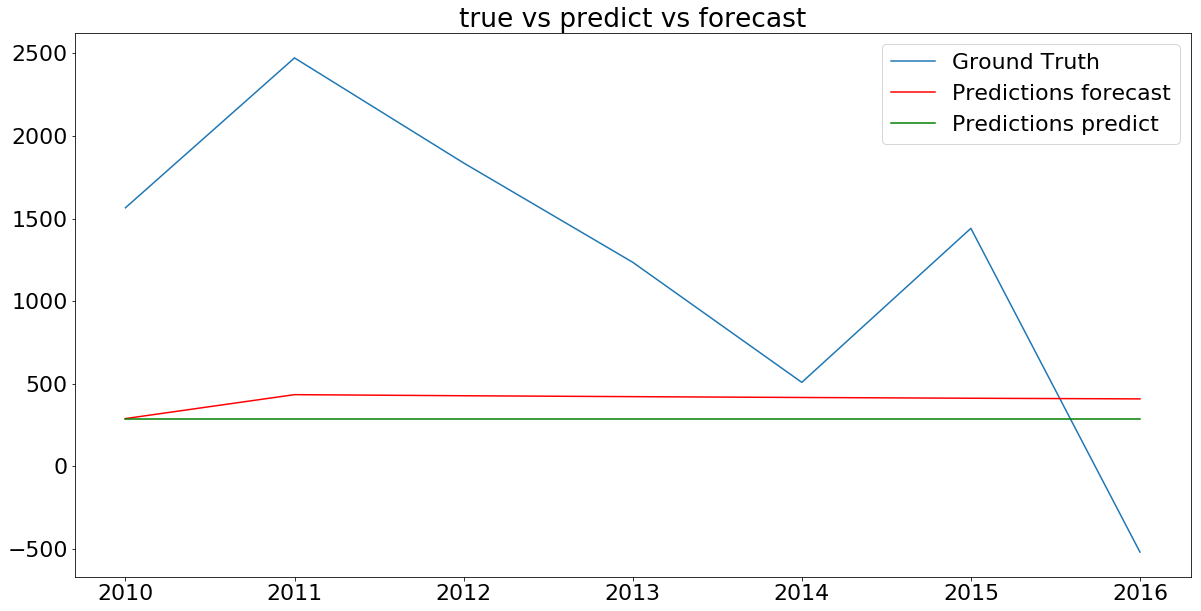

In [51]:
# 把真实值，predict, forecast的值比较
year = range(2010,2017)
plt.plot(year,test, label='Ground Truth')
plt.plot(year,arima['Predictions forecast'], color='red',label='Predictions forecast')
plt.plot(year,arima['Predictions predict'], color='green', label='Predictions predict')
plt.legend()
plt.title('true vs predict vs forecast')
plt.show()

更简单的实现方式,使用内置函数forecast预测未来7年的值

In [52]:
# from statsmodels.tsa.arima_model import ARMA
# model = ARMA(train, order = order.bic_min_order)
# result_arma = model.fit(disp=-1, method='css')

# # 预测未来7天的值
# n = len(test_data)
# pred= result_arma.forecast(n)[0]

# # 转换为list
# pre_list = pred

# before_diff = before_diff.tolist()

In [58]:
# 转换为list
pre_list = arima['Predictions forecast']

before_diff = before_diff.tolist()

In [59]:
before_diff

[53082.07765,
 54647.712,
 57120.84906,
 58957.96606,
 60193.84002999999,
 60702.6,
 62143.9,
 61625.0]

In [60]:
# 把一阶差分还原成food_output
restore_pre_list = []
for i in range(len(pre_list)):
    true = pre_list[i] + before_diff[i]
    restore_pre_list.append(true)
print(restore_pre_list)

[53371.53238440166, 55106.19130474471, 57562.97866936694, 59400.85188115402, 60636.41232893217, 61145.27920887093, 62586.55255041123]


In [66]:
true = df.food_output[20:] # 测试集
true = true.tolist()

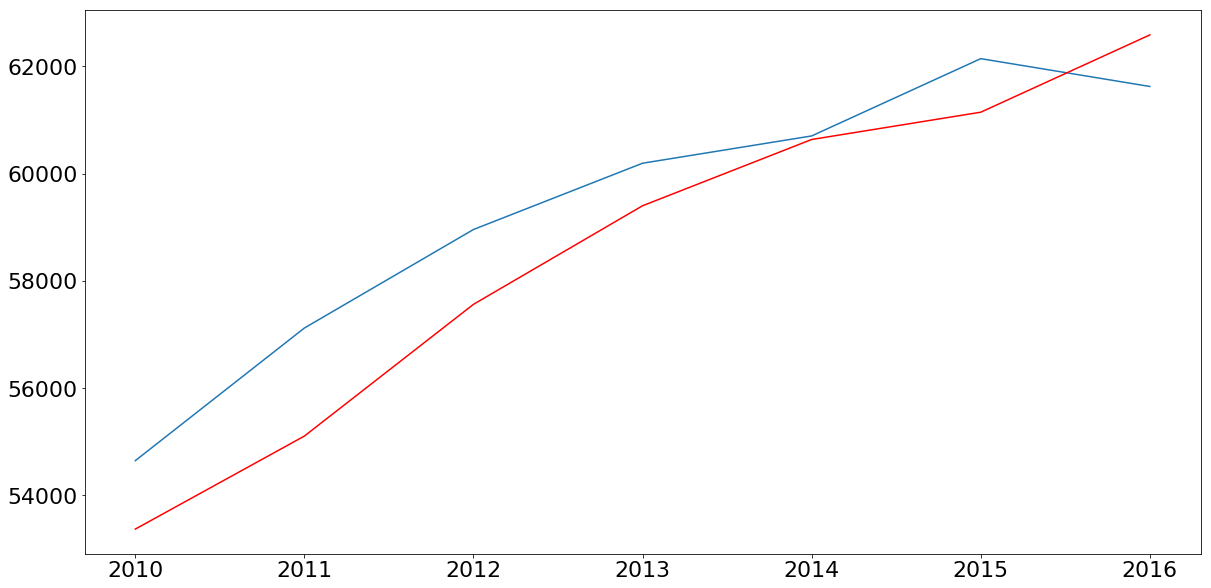

In [67]:
year = range(2010,2017)
plt.plot(year,true)
plt.plot(year,restore_pre_list, color='red')
plt.show()

In [68]:
error = sum(list(map(lambda x:abs(abs(x[0] - x[1])/(x[1])), zip(restore_pre_list,true))))
error = error/len(true)
print('error ',float(error)*100,'%')
ARIMA = restore_pre_list

('error ', 1.8317242459601997, '%')


- 误差为 0.488%, 为最低的误差

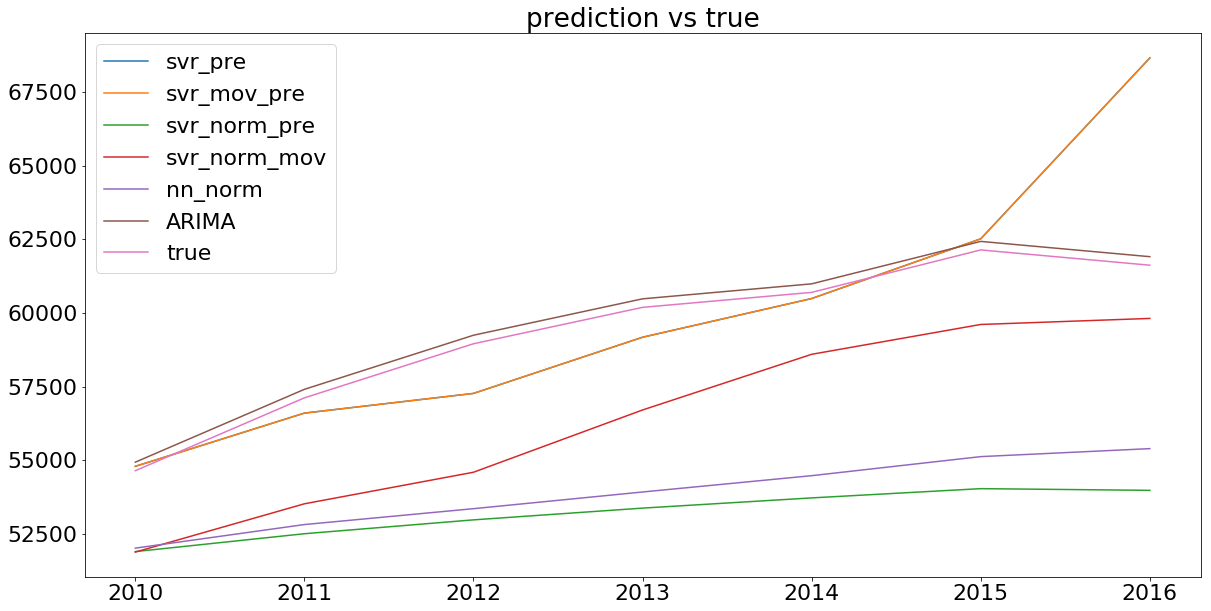

In [58]:
plt.plot(year,svr_pre,label='svr_pre')
plt.plot(year,svr_mov_pre,label='svr_mov_pre')
plt.plot(year,svr_norm_pre,label='svr_norm_pre')
plt.plot(year,svr_norm_mov,label='svr_norm_mov')
plt.plot(year,nn_norm,label='nn_norm')
plt.plot(year,ARIMA,label='ARIMA')
plt.plot(year,true_restore,label='true')
plt.legend(loc='upper left')
plt.title("prediction vs true")
plt.show()